In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# notebook written on python 3.6.7

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import h5py

import os
import sys
import time
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import matplotlib_funs as mpf
import numerical_funs as nf

# First we have to load the OMC data

In [3]:
hf = h5py.File('./H1_OMC_PZT2_MON_DC_OUT_DQ-1219517958-270.h5','r')

g1 = hf[list(hf.keys())[0]]
g2 = g1[list(g1.keys())[0]]

pzt_LHO = g2[:]

hf.close()

T = 270 # length of sample
N = len(pzt_LHO)
t0 = 1219517958
dt = T/N
ts_pzt = np.arange(N)*dt + t0

hf = h5py.File('./data_LHO.h5','r')

scans_LHO = []
keys_LHO = []

for key in hf.keys():
    keys_LHO.append(key)
    scans_LHO.append(hf[key][:])
    
hf.close()

idxs_LHO = []

for key in keys_LHO:
    idx = np.argmin(np.abs(ts_pzt-float(key[:-5])))
    idxs_LHO.append(idx)

V_LHO_alexei = pzt_LHO[idxs_LHO]

t_LHO = np.arange(len(scans_LHO[0]))/2.0**14

In [4]:
# getiing LLO voltages

hf = h5py.File('./L1_OMC_PZT2_MON_DC_OUT_DQ-1225734623-700.h5','r')

g1 = hf[list(hf.keys())[0]]
g2 = g1[list(g1.keys())[0]]

pzt_LLO = g2[:]

hf.close()

T = 700 # length of sample
N = len(pzt_LLO)
t0 = 1225734623
dt = T/N
ts_pzt = np.arange(N)*dt + t0

hf = h5py.File('./data_LLO.h5','r')

keys_LLO = []
scans_LLO = []

for key in hf.keys():
    scans_LLO.append(hf[key][:])
    keys_LLO.append(key)
    
hf.close()

idxs_LLO = []

for key in keys_LLO:
    idx = np.argmin(np.abs(ts_pzt-float(key[:-5])))
    idxs_LLO.append(idx)

V_LLO_alexei = pzt_LLO[idxs_LLO]

scans_LLO = scans_LLO[0:2]
V_LLO_alexei = V_LLO_alexei[0:2]

t_LLO = np.arange(len(scans_LHO[0]))/2.0**14

/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_LLO_OMC_TMS_splitting/../second_order_peak_LHO_LLO.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_LLO_OMC_TMS_splitting/../second_order_peak_LHO_LLO.pdf


0

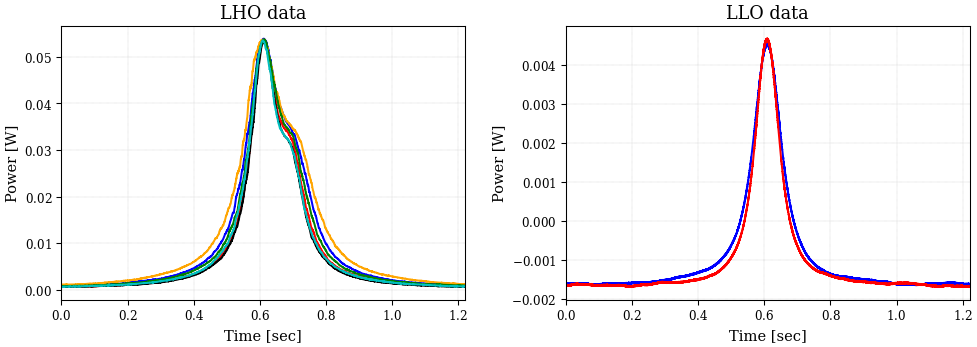

In [5]:
fig, ax = mpf.subplots(1,2)

plt.sca(ax[0])
for scan in scans_LHO:
    plt.plot(t_LHO,scan)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.title('LHO data')
plt.grid(True)

plt.sca(ax[1])
for scan in scans_LLO:
    plt.plot(t_LLO,scan)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.title('LLO data')
plt.grid(True)

mpf.thesis_savefig(fig, '../second_order_peak_LHO_LLO')

Note that even though every second order peak follows the same shape the width of the peak seems to change depending on which peak we are looking at. There are two possible explanations for this.

* The finesse of the OMC varies slowly (on the order of seconds) as a function of time.
* The rate at which the pzt changes length varies as across the scan.

I don't have any reason to believe that the finesse of the OMC would change on those sorts of timescales, much less for those changes to be visible in an OMC scan. The PZT on the other hand is known have noticeable hysterisis. This manifests itself as the PZT responding nonlinearly to voltage over large voltage ranges.

For the purposes of extracting the OMC astigmatism the inconsistent scan rate doesn't pose much of an issue if we make two key assumptions:

* The PZT nonlinearity is sufficiently small such that the scan rate is linear over the course of 1 second
* The finesse and the FSR of the OMC is constant.

This allows us to avoid fitting lopsided lorentzians that have been distorted due to nonlinear scan rate. We can also use the fitted lorentzian as a ruler to calibrate the scan rate over a small time interval.

# Optimization

Here we will have to employ non-linear least squares to fit the function

In [6]:
def lorentzian(x,fwhm=1,x0=0):
    '''maximum of lorentzian is 1.0'''
    return (fwhm/2)**2/((x-x0)**2+(fwhm/2)**2)

In [7]:
_t_lstsq_sol = [None]
def objective_function(theta, x, y, lstsq_sol=None, mode='resid'):
    fwhm,x0,x1 = theta
    N = len(x)
    
    a = np.zeros([N,3])
    a[:,0] = np.ones(N)
    a[:,1] = lorentzian(x, fwhm, x0)
    a[:,2] = lorentzian(x, fwhm, x1)
    
    if lstsq_sol is None:
        lstsq_sol, *_ = np.linalg.lstsq(a, y, rcond=None)
        # print(lstsq_sol)
        _t_lstsq_sol[0] = lstsq_sol # write lstsq solution to global
    
    model = np.sum(lstsq_sol*a, axis=1)
    
    if mode == 'resid':
        out =  y-model
    elif mode == 'model':
        out = model
    return out

In [8]:
init = [0.1, 0.6, 0.7]
solns_LHO = []
for i,scan in enumerate(scans_LHO):
    print(i, end='\r')
    soln = scipy.optimize.least_squares(objective_function, init, args=(t_LHO, scan), ftol=3e-16, gtol=3e-16, xtol=3e-16)
    solns_LHO.append((soln.x,_t_lstsq_sol[0]))

In [9]:
resids_LHO = []
for soln, scan in zip(solns_LHO, scans_LHO):
    soln, lstsq_sol = soln
    resid = objective_function(soln, t_LHO, scan, lstsq_sol)
    resids_LHO.append(resid)

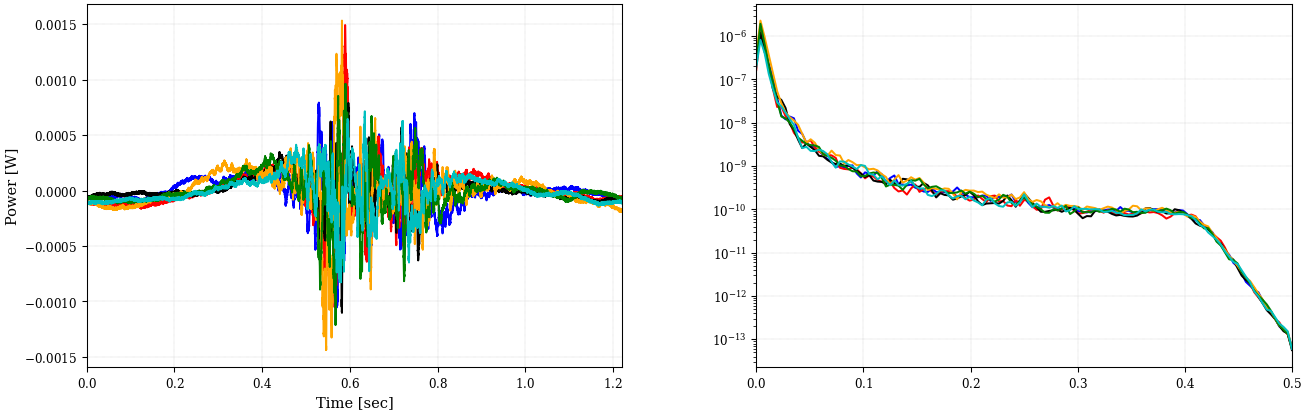

In [10]:
fig, ax = mpf.subplots(1,2)

plt.sca(ax[0])
for resid in resids_LHO:
    plt.plot(t_LHO, resid)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.grid(True)

plt.sca(ax[1])
for resid in resids_LHO:
    plt.semilogy(*scipy.signal.welch(resid))

In [11]:
tms_LHO = []
for soln in solns_LHO:
    soln, _ = soln
    fwhm, x0, x1 = soln
    tms_LHO.append(np.abs(x0-x1)/fwhm/2)

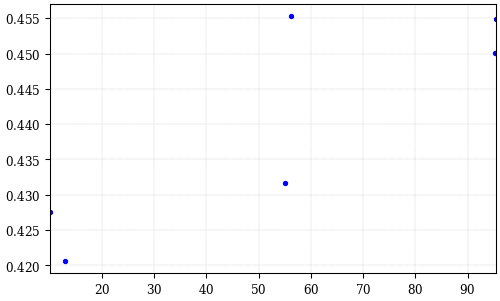

In [12]:
plt.plot(V_LHO_alexei, tms_LHO, '.')

# Repeat for LLO

In [13]:
init = [0.08, 0.6, 0.63]
solns_LLO = []
for i,scan in enumerate(scans_LLO):
    print(i, end='\r')
    soln = scipy.optimize.least_squares(objective_function, init, args=(t_LLO, scan), ftol=3e-16, gtol=3e-16, xtol=3e-16)
    solns_LLO.append((soln.x, _t_lstsq_sol[0]))

In [14]:
resids_LLO = []
for soln, scan in zip(solns_LLO, scans_LLO):
    soln, lstsq_sol = soln
    resid = objective_function(soln, t_LLO, scan, lstsq_sol)
    resids_LLO.append(resid)

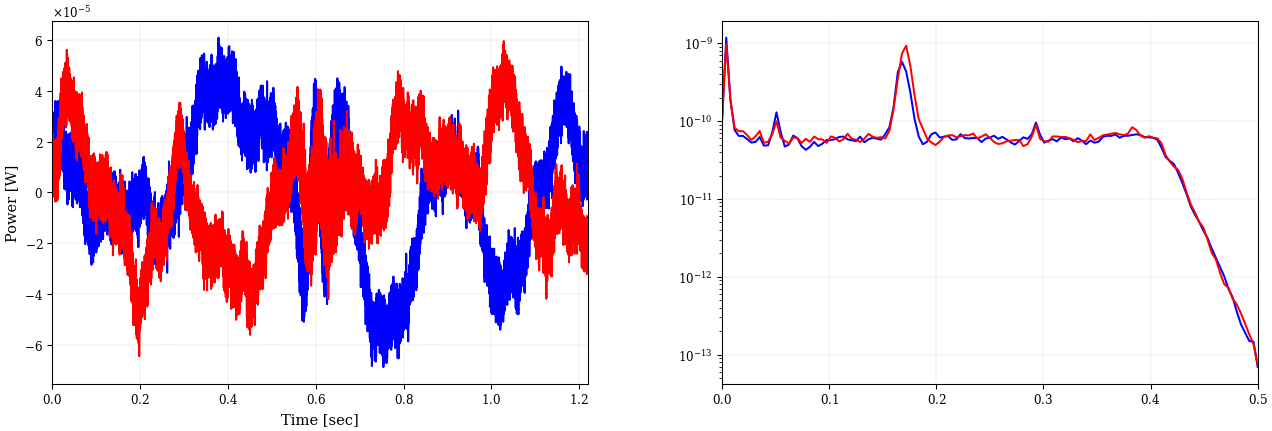

In [15]:
fig, ax = mpf.subplots(1,2)

plt.sca(ax[0])
for resid in resids_LLO:
    plt.plot(t_LLO, resid)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.grid(True)

plt.sca(ax[1])
for resid in resids_LLO:
    plt.semilogy(*scipy.signal.welch(resid))

/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_LLO_OMC_TMS_splitting/../second_order_peak_LHO_LLO_residuals.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_LLO_OMC_TMS_splitting/../second_order_peak_LHO_LLO_residuals.pdf


0

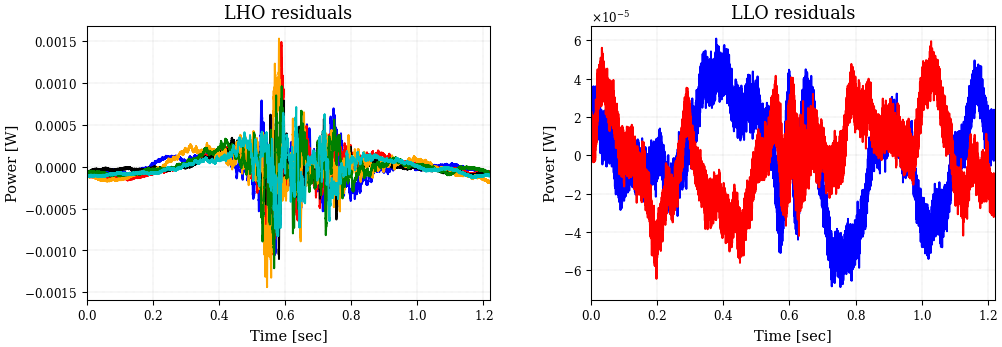

In [16]:
fig, ax = mpf.subplots(1,2)

plt.sca(ax[0])
for resid in resids_LHO:
    plt.plot(t_LHO, resid)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.title('LHO residuals')
plt.grid(True)

plt.sca(ax[1])
for resid in resids_LLO:
    plt.plot(t_LLO, resid)
plt.xlabel('Time [sec]')
plt.ylabel('Power [W]')
plt.title('LLO residuals')
plt.grid(True)

mpf.thesis_savefig(fig, '../second_order_peak_LHO_LLO_residuals')

In [17]:
tms_LLO = []
for soln in solns_LLO:
    soln, _ = soln
    fwhm, x0, x1 = soln
    tms_LLO.append(np.abs(x0-x1)/fwhm/2)

In [28]:
print(np.mean(tms_LHO), np.std(tms_LHO))
print(np.mean(tms_LLO), np.std(tms_LLO))

0.440039810777 0.0138953883379
0.167190112027 0.00644997790897


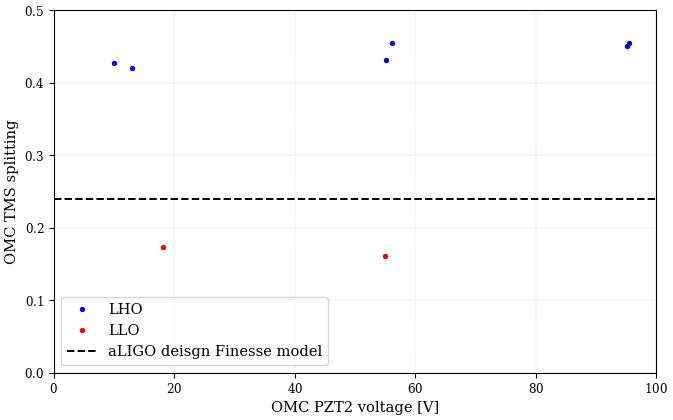

In [18]:
finesse_astig = 0.2396
fig, ax = mpf.subplots(1,1)
plt.plot(V_LHO_alexei, tms_LHO, '.', label='LHO')
plt.plot(V_LLO_alexei, tms_LLO, '.', label='LLO')
plt.axhline(finesse_astig, c='k', ls='--', label='aLIGO deisgn Finesse model')
plt.xlabel('OMC PZT2 voltage [V]')
plt.ylabel('OMC TMS splitting')
plt.xlim([-0,100])
plt.ylim([-0,0.5])
plt.legend()
# mpf.thesis_savefig(fig, '../LHO_LLO_OMC_TMS_splitting')